## Imports and removing hetatms

In [1]:
from itertools import chain
import numpy as np
from Bio.PDB import *
import os
import warnings
import os
import matplotlib.pyplot as plt
import random
amino3CodesStr = 'alaargasnaspcysgluglnglyhisileleulysmetpheproserthrtrptyrval'
amino3Codes = [amino3CodesStr[x:x+3].upper() for x in range(0, len(amino3CodesStr), 3)]
amino3Codes = list(sorted(amino3Codes))
print(amino3Codes, len(amino3Codes)) 
os.makedirs("cleanGeneral")
for filename in os.listdir("generalData/PDBStr"):
    allProteins = open("generalData/PDBStr/"+filename, 'r')
    onlyATMs = open('cleanGeneral/'+filename, 'w')
    for line in allProteins:
        if (line[0:6] != "HETATM"):
            onlyATMs.write(line)
    allProteins.close()
    onlyATMs.close()

['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'] 20


## Count fraction of repeating and Count interactions

In [2]:
with open("generalData\pdb_4960list.txt", "r") as f:
    i = 0
    counter = 0
    for l in f.readlines():
        counter+=1
        lineList = l.strip().split()
        pdbName = lineList[1] + '.pdb'
        chainNames = [lineList[2], lineList[5]]
        if chainNames[0] == chainNames[1]:
            i+=1
    print(i, counter)

919 4144


In [5]:
os.makedirs("generalMatchData")
parser = PDBParser()
errorPDBNames = []
with open("generalData\pdb_4960list.txt", "r") as f:
    for l in f.readlines():
        lineList = l.strip().split()
        pdbName = lineList[1] + '.pdb'
        chainNames = [lineList[2], lineList[5]]
        if chainNames[0] != chainNames[1]:
            # add to the official list
            protein = parser.get_structure(pdbName[:-4], "cleanGeneral/"+pdbName)
            chains = list(list(protein.get_models())[0].get_chains())
            chainL, chainH = [], []
            for x in chains:
                if x.id == chainNames[0]:
                    chainL = list(x.get_residues())
                if x.id == chainNames[1]:
                    chainH = list(x.get_residues())
            resA, resB = chainL, chainH
            AAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resA if x.get_resname() in amino3Codes])) 
            BAtomList = list(chain.from_iterable([list(x.get_atoms()) for x in resB if x.get_resname() in amino3Codes]))
            
            if len(BAtomList) == 0 or len(AAtomList)==0:
                errorPDBNames.append(pdbName)
                continue
            NBSearch, NBSearch3 = NeighborSearch(AAtomList), NeighborSearch(BAtomList)
            InteractingAList = []
            for res in resB:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch.search(centerPos, 5, 'R')) > 0:
                        InteractingAList.append(res)
                        break
            InteractingBList = []
            for res in resA:
                for atm in list(res.get_atoms()):
                    centerPos = atm.coord
                    if len(NBSearch3.search(centerPos, 5, 'R')) > 0:
                        InteractingBList.append(res)
                        break

            AInteractionList, BInteractionList = {}, {}
            for i in range(len(amino3Codes)):
                for j in range(i, len(amino3Codes)):
                    combinationName = amino3Codes[i] + " " + amino3Codes[j]
                    AInteractionList[combinationName] = 0
                    BInteractionList[combinationName] = 0
            ### Count intra-Ag interactions -> dict
            atms = [r.get_atoms() for r in InteractingAList if r.get_resname() in amino3Codes]
            NBSearch2 = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
            AInteractions = NBSearch2.search_all(5, level='R')
            for (r1, r2) in AInteractions:
                combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                AInteractionList[combinationName] += 1
            
            atms = [r.get_atoms() for r in InteractingBList if r.get_resname() in amino3Codes]
            NBSearch2 = NeighborSearch(list(chain.from_iterable(atms))) # Count interactions using neighbor search
            BInteractions = NBSearch2.search_all(5, level='R')
            for (r1, r2) in BInteractions:
                combinationName = min([r1.get_resname(), r2.get_resname()]) + " " + max([r1.get_resname(), r2.get_resname()])
                BInteractionList[combinationName] += 1

            ### Save dict as normalized chart numpy 2d array
            # Create frequency chart/triangle using the alphabetized amino codes
            AfreqChart = np.empty((20, 20))
            AfreqChart.fill(np.nan)
            for r in range(len(amino3Codes)):
                for c in range(r, len(amino3Codes)):
                    fst, snd = amino3Codes[r], amino3Codes[c]
                    combinationName = fst + " " + snd
                    count = AInteractionList[combinationName]
                    AfreqChart[r, c] = count
            BfreqChart = np.empty((20, 20))
            BfreqChart.fill(np.nan)
            for r in range(len(amino3Codes)):
                for c in range(r, len(amino3Codes)):
                    fst, snd = amino3Codes[r], amino3Codes[c]
                    combinationName = fst + " " + snd
                    count = BInteractionList[combinationName]
                    BfreqChart[r, c] = count
            # Normalize
            AfreqChart -= np.nanmin(AfreqChart)
            BfreqChart -= np.nanmin(BfreqChart)
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    AfreqChart /= (np.nanmax(AfreqChart) - np.nanmin(AfreqChart))
                    BfreqChart /= (np.nanmax(BfreqChart) - np.nanmin(BfreqChart))
                except:
                    errorPDBNames.append(pdbName)
                    continue

            ### Make matches
            flippedAb = np.flipud(AfreqChart)
            matchFreqChart = np.concatenate([flippedAb, BfreqChart], axis=1)
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                try:
                    matchFreqChart = np.array([r[~np.isnan(r)] for r in matchFreqChart])
                except:
                    errorPDBNames.append(pdbName)
                    continue
            
            with open("generalMatchData/"+pdbName[:-4]+".npy", "wb") as f:
                np.save(f, matchFreqChart)

c:\Python310\lib\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE1) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)
c:\Python310\lib\site-packages\Bio\PDB\Atom.py:232: PDBConstructionWarning: Could not assign element 'X' for Atom (name=XE2) with given element 'X'
  warnings.warn(msg, PDBConstructionWarning)


In [7]:
print(len(errorPDBNames), errorPDBNames)

7 ['1gu8.pdb', '2vo1.pdb', '1cm4.pdb', '1pci.pdb', '1cjl.pdb', '2cse.pdb', '1lhg.pdb']


In [8]:
len(os.listdir("generalMatchData"))

3218

In [10]:
matchingArr = []
for filename in os.listdir("matchData"):
    matchingArr.append(np.load("matchData/"+filename))
mismatchArr = []
for filename in os.listdir("generalMatchData"):
    mismatchArr.append(np.load("generalMatchData/"+filename))

data, labels = [], []
for arr in matchingArr:
    data.append(arr)
    labels.append(1)
for arr in mismatchArr:
    data.append(arr)
    labels.append(0)
data = np.array(data)
labels = np.array(labels).reshape(-1, 1)
print(labels[0])

[1]


In [11]:
len(matchingArr)

1215

Plotting examples (note: 1214/1215 is the index border between the Ab/Ag matches and general proteins)

[0]


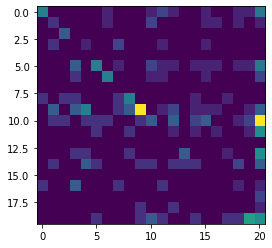

In [12]:
plt.imshow(data[1215])
print(labels[1215])

Plotting examples of matching pairs

Text(0.5, 0.98, 'Example Matching Combined Residue Interaction Relative Frequencies of Ab/Ag Dataset')

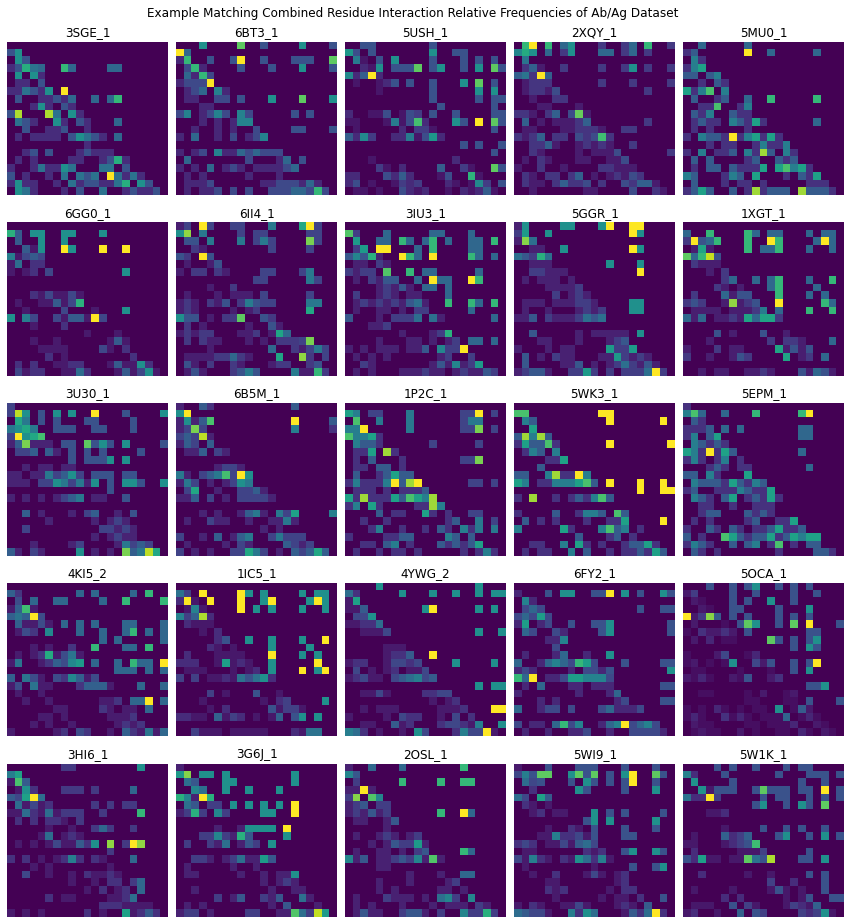

In [21]:
sampleRange1 = random.sample(range(len(matchingArr)), 25)
randomMatches = data[sampleRange1]
mapNames = [os.listdir("matchData")[x] for x in sampleRange1]
mapNames = [x[9:-4] for x in mapNames]
k=5
fig, axes = plt.subplots(k, k, figsize=(15, 15))
for i in range(k):
    for j in range(k):
        axes[i, j].axis("off")
        axes[i, j].imshow(randomMatches[i*5+j])
        axes[i, j].set_title(mapNames[i*5+j])
plt.subplots_adjust(top=0.96, wspace=0.05, hspace=0)
fig.suptitle("Example Matching Combined Residue Interaction Relative Frequencies of Ab/Ag Dataset")

Plotting general protein pairs

Text(0.5, 0.98, 'Example Nonmatching Combined Residue Interaction Relative Frequency of Ab/Ag Dataset')

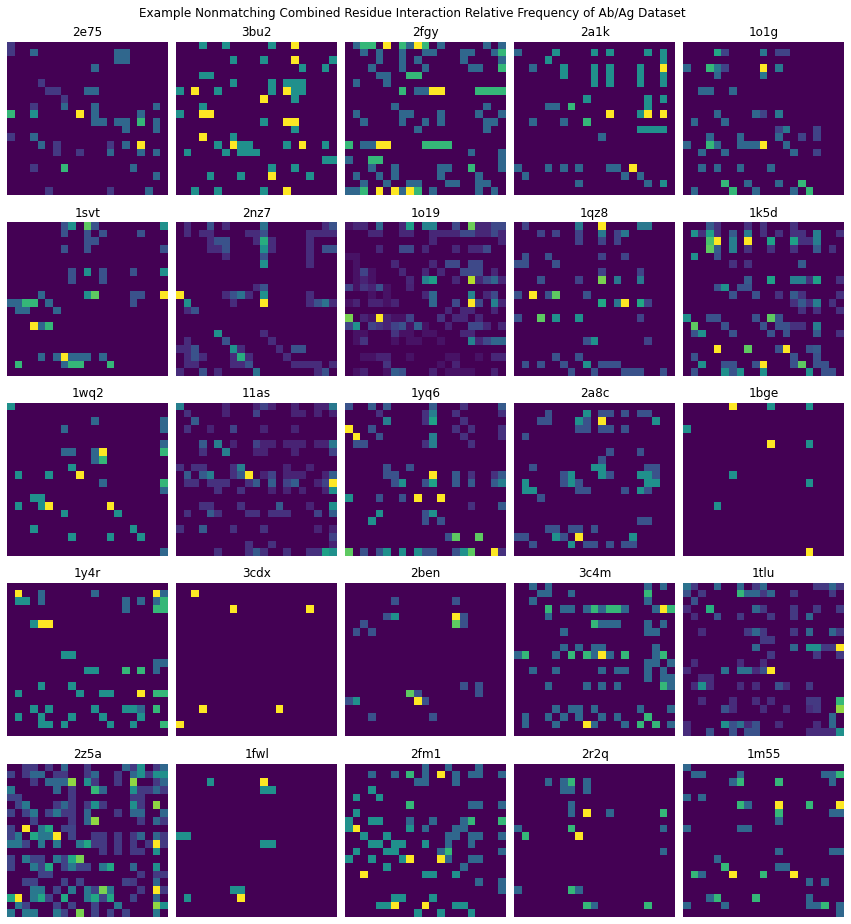

In [22]:
sampleRange2 = random.sample(range(len(matchingArr), len(data)), 25)
randomMatches = data[sampleRange2]
mapNames = [os.listdir("generalMatchData")[x-len(matchingArr)] for x in sampleRange2]
mapNames = [x[:-4] for x in mapNames]
k=5
fig, axes = plt.subplots(k, k, figsize=(15, 15))
for i in range(k):
    for j in range(k):
        axes[i, j].axis("off")
        axes[i, j].imshow(randomMatches[i*5+j])
        axes[i, j].set_title(mapNames[i*5+j])
plt.subplots_adjust(top=0.96, wspace=0.05, hspace=0)
fig.suptitle("Example Nonmatching Combined Residue Interaction Relative Frequency of Ab/Ag Dataset")

## CNN for classification

### Function to create the model

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout
from keras import applications
def create_model():
    # base_model=applications.VGG16(include_top=False, weights='imagenet',input_tensor=Input(shape=(20, 21, 1)))
    # for layer in base_model.layers:
    #     layer.trainable = False
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(20,21,1)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    #model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    #model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

### Training and Testing and 10-fold CV

In [17]:
def plot_roc_curve(fpr,tpr):
    fig = plt.figure(figsize=(15, 15)) 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.title("ROC Curve for Ab/Ag and General Combined Internal Residue Combination Frequency Chart Prediction")
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

Epoch 1/1000
285/285 [==============================] - 3s 9ms/step - loss: 0.6350 - accuracy: 0.7059 - precision: 0.2101 - recall: 0.0265 - val_loss: 0.5821 - val_accuracy: 0.7252 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
285/285 [==============================] - 2s 8ms/step - loss: 0.5619 - accuracy: 0.7260 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5322 - val_accuracy: 0.7252 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
285/285 [==============================] - 2s 8ms/step - loss: 0.4862 - accuracy: 0.7293 - precision: 1.0000 - recall: 0.0119 - val_loss: 0.4202 - val_accuracy: 0.7613 - val_precision: 1.0000 - val_recall: 0.1311
Epoch 4/1000
285/285 [==============================] - 2s 8ms/step - loss: 0.3371 - accuracy: 0.8674 - precision: 0.9796 - recall: 0.5270 - val_loss: 0.2528 - val_accuracy: 0.9595 - val_precision: 0.9561 - val_recall: 0.8934
Epoch 5/1000
285/285 [==============================] - 2s 8ms/step - lo

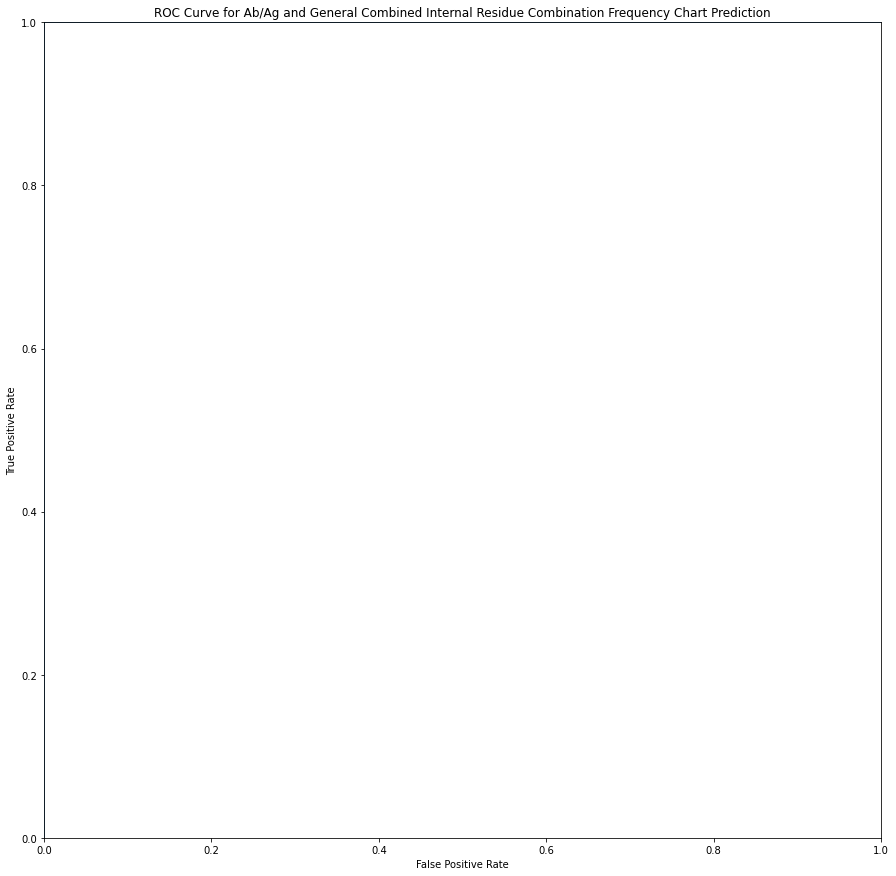

1.0
[0.99842088 0.01379772 0.99994375 0.99672798 0.99754099 0.99712268]


In [18]:
from sklearn.model_selection import StratifiedKFold
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import roc_curve, roc_auc_score

kfold = StratifiedKFold(10, shuffle=True, random_state=9001)
accs, aucs, losses, precs, recs, f1s = [np.zeros(10) for _ in range(6)]

for i, (trainInds, testInds) in enumerate(kfold.split(data, labels)):
    # if i == 1:
    #     break
    model = create_model()
    X_train, X_test, y_train, y_test = data[trainInds], data[testInds], labels[trainInds], labels[testInds]
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy', Precision(), Recall()])
    # print(model.summary())
    
    # best_weights_file="weights.best.hdf5"
    # checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    es = EarlyStopping('val_accuracy', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=14,
                        validation_data=(X_test, y_test), callbacks=(es))
    # print(model.metrics_names)
    test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=1)
    accs[i] = test_acc
    losses[i] = test_loss
    precs[i] = test_prec
    recs[i] = test_rec
    test_f1 = 2 * (test_prec * test_rec) / (test_prec + test_rec)
    f1s[i] = test_f1
    prediction = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    auc_score=roc_auc_score(y_test, prediction)
    aucs[i] = auc_score
    if i == 9:
        plot_roc_curve(fpr,tpr)
        print(auc_score)
print(np.mean(np.array([accs, losses, aucs, precs, recs, f1s]), axis=1))